# Data Scientist Take Home Task

This notebook includes a small data pipeline, to extract, clean, tranform, visualize and forecast vacancy time series data from the ONS.

## 1. Data Ingestion and Automation

The following code downloads a subset of the ONS vacancy data available on their website. The CSV files are stored in the `data/raw` folder.

First, I import the necessary libraries and the config file.

In [ ]:
# Import necessary libraries

import os # for file path operations
import configparser # to read configuration file
import pandas as pd # for data manipulation
import numpy as np # for numerical operations
import requests # to download data from ONS website
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator # for controlling tick marks
import seaborn as sns # for plotting
from statsmodels.tsa.stattools import adfuller # for ADF test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # for ACF and PACF plots
from statsmodels.tsa.arima.model import ARIMA # for ARIMA modeling

In [61]:
# Read config file
config = configparser.ConfigParser()
config.read('config/config.ini')

['config/config.ini']

Next, I download the raw CSV files from the ONS website. The URLs of the most recent and the previous vintage, as well as the number of previous vintages to download need to be specified in the `config.ini` file.

```python

In [ ]:
# Get URL and number of previous files to download from config file
url_latest = config['INGESTION']['url_latest'] # URL of the latest file
url_first_previous = config['INGESTION']['url_first_previous'] # URL of the first previous file (URLs for other files will be derived from this)
number_of_previous_files = int(config['INGESTION']['number_of_previous_files']) # Number of previous files to download

# Dowload the latest file and save in data folder
r = requests.get(url_latest, verify = False) # Download the file
with open("data/raw/ons_vacancies_0.csv", "wb") as f: # Save the file
    f.write(r.content)

# Dowload the previous files and save in data folder
for i in range(number_of_previous_files): # Loop to download previous files
    version_number = url_first_previous.split("v")[-1].split("/")[0]
    new_version = int(version_number) - i
    r = requests.get(url_first_previous.replace(f"v{version_number}", f"v{new_version}"), verify = False)
    with open(f"data/raw/ons_vacancies_{i+1}.csv", "wb") as f:
        f.write(r.content)

## 2. Data Cleaning and Structuring

In this section, I append the downloaded CSV files into a single DataFrame, clean the data, and structure it in a time series format. The cleaned data contains the following columns: `date`, `vacancies` and `vintage`.


In [ ]:
# Loop over all files, clean them, and append them to single dataframe

df = pd.DataFrame() # Create empty dataframe to append data to

for i in range(number_of_previous_files + 1):
    file_name = f"data/raw/ons_vacancies_{i}.csv" # File path
    df_temp = pd.read_csv(file_name) # Read the file
    df_temp = pd.concat([df_temp[df_temp['Title'] == 'Release date'], 
                         df_temp.iloc[df_temp[df_temp['Title'] == '2001 MAY'].index[0] : ]]) # Kepp only vintage row and monthly data
    df_temp.reset_index(drop=True, inplace=True) # Reset index
    df_temp['vintage'] = df_temp.iloc[0, 1] # Create new column with vintage
    df_temp = df_temp.drop(index=0) # Drop vintage row
    df_temp = df_temp.rename(columns = {df_temp.columns[0]: 'date', 
                                        df_temp.columns[1]: 'vacancies', 
                                        df_temp.columns[2]: 'vintage' }) # Rename columns
    df = pd.concat([df, df_temp], ignore_index=True) # Append to main dataframe


# Change vacancies to integer type
df['vacancies'] = df['vacancies'].astype(int)

# Change vintages to datetime type
df['vintage'] = pd.to_datetime(df['vintage'], format='%d-%m-%Y')

# Change dates to datetime type
df['date'] = pd.to_datetime(df['date'], format='%Y %b')


# Examine the first ten rows of the cleaned data
df.head(10)


In [ ]:
# Datatypes
print(df.dtypes)

In [ ]:
# Plot vacancies across vintages for selected month.

# Select the month to plot(YYYY-MM-DD format)
month_to_plot = '2025-01-01'

# Create subset of df for selected month
df_month = df[df['date'] == month_to_plot]

# Plot vacacncies for selected month over different vintages.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_month, x='date', y='vacancies', hue=df_month['vintage'].dt.date, s=200)
plt.title(f'Vacancies for {month_to_plot} over different vintages')
plt.xlabel('Month')
plt.ylabel('Number of Vacancies (thousands)')
plt.xticks(rotation=45)
plt.legend(title='Vintage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


Next, I plot how vacancies for given month have changed from first to latest vintage.

In [ ]:
# First, pivot the dataframe to have vintages as columns
df_pivot = df.pivot_table(index='date', columns='vintage', values='vacancies')

# Sort columns by vintage date
df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

# Calculate the revision from first vintage that does not have a non-missing value to latest vintage
def calculate_revision(row):
    first_valid_index = row.first_valid_index()
    if first_valid_index is not None:
        return row.iloc[-1] - row[first_valid_index]
    else:
        return np.nan
    
df_pivot['revision'] = df_pivot.apply(calculate_revision, axis=1)


# Sort the data by date
df_pivot = df_pivot.sort_values(by='date')

In [ ]:
# Plot the revisions
plt.figure(figsize=(12, 6))
sns.barplot(data=df_pivot, x='date', y='revision', palette='viridis')
plt.title('Revisions in Vacancies from First to Latest Vintage', size = 16)
plt.xlabel('Month', size = 14)
plt.ylabel('Revision in Number of Vacancies (thousands)', size = 14)
plt.xticks(ticks=plt.gca().get_xticks()[::12], rotation = 45)
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

There are three notable observations:
1) Revisions tend to be larger for more recent months.
2) From 2022 to 2024, revisions were persistently negative.
3) During the pre-pandemic period, revisions tended to be positive from May to October, and negative from November to April.

## 4. Forecasting

In  this section, I forecast vacancies using an autoregressive integrated moving average (ARIMA) model.



In a first step, I plot the vacancy time series for the latest vintage.

In [ ]:
# Plot time series for latest vintage
latest_vintage = df['vintage'].max() # Get the latest vintage
df_latest = df[df['vintage'] == latest_vintage] # Filter data for the latest vintage

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_latest, x='date', y='vacancies', marker='o')
plt.title(f'Vacancies Time Series - Latest Vintage: {latest_vintage.date()}', size = 16)
plt.xlabel('Month', size = 14)
plt.ylabel('Number of Vacancies (thousands)', size = 14)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.tight_layout()
plt.show()


The time series shows signs of seasonal patterns, and is likely to be non-stationary. I will formally test for stationarity using the Augmented Dickey-Fuller test.

In [ ]:
ts = df_latest.set_index('date')['vacancies']
result = adfuller(ts)
print(f'ADF Statistic: {result[0]}', f'p-value: {result[1]}')

if result[1] <= 0.05:
    print("The p-value is smaller or equal to 5%, so the H0 that the time series is non-stationary can be rejected ")
else:
    print("The p-value is larger than 5%, so the H0 that the time series is non-stationary cannot be rejected ")

The following code will first difference the time series in case the ADF test indicated non-stationarity. Then, I will create  ACF and PACF plots to determine the parameters for the ARIMA model. The PACF (Partial Autocorrelation Function) plot shows the direct correlation between the first difference of the time series and its lagged values, while the ACF (Autocorrelation Function) plot shows the overall correlation between the first difference of the time series and its lagged values.

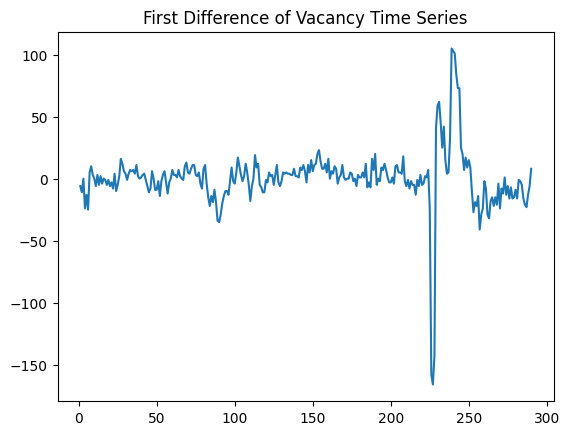

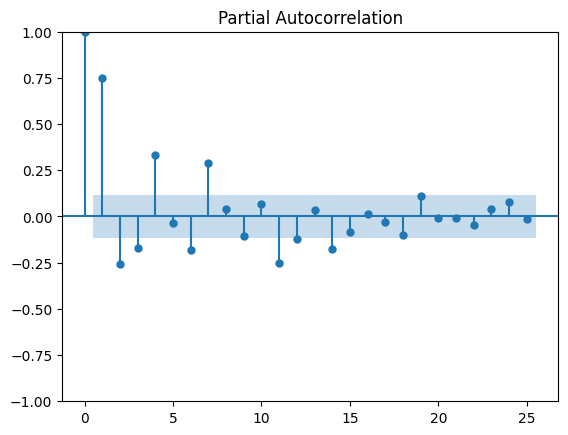

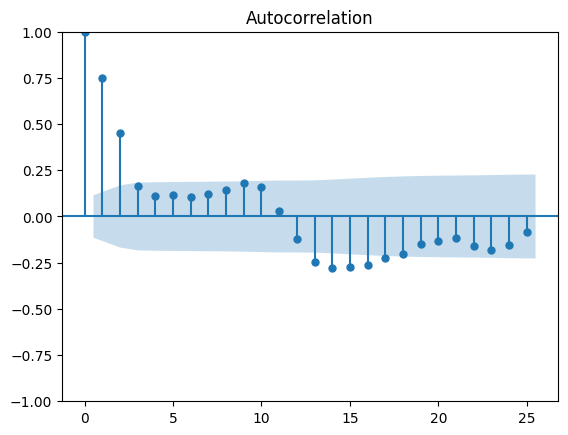

In [45]:
if result[1] > 0.05:
    ts_diff = df_latest['vacancies'].diff().dropna()
    ts_diff.plot(title='First Difference of Vacancy Time Series')
    plt.show()

plot_pacf(ts_diff)
plot_acf(ts_diff)

plt.show()


The PACF plot suggests an AR(1) process because the PACF cuts off after lag 1. The ACF plot shows a gradual decline, which is typical for an AR process. Therefore, I will set the ARIMA parameters to (p=1, d=1, q=0). If you want to change these parameters for future updates, please adjust the parameters in the config file.

In [64]:
p = int(config['FORECAST']['p'])
q = int(config['FORECAST']['q'])
d = int(config['FORECAST']['d'])

model = ARIMA(ts, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              vacancies   No. Observations:                  291
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1205.902
Date:                Mon, 06 Oct 2025   AIC                           2417.804
Time:                        11:49:20   BIC                           2428.814
Sample:                    05-01-2001   HQIC                          2422.215
                         - 07-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9417      0.048     19.575      0.000       0.847       1.036
ar.L2         -0.2547      0.051     -5.031      0.000      -0.354      -0.156
sigma2       238.7352      7.727     30.897      0.0

c:\Miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2025-08-01    737.062317
2025-09-01    743.558557
2025-10-01    747.367626
2025-11-01    749.299819
2025-12-01    750.149061
2026-01-01    750.456590
Freq: MS, Name: predicted_mean, dtype: float64


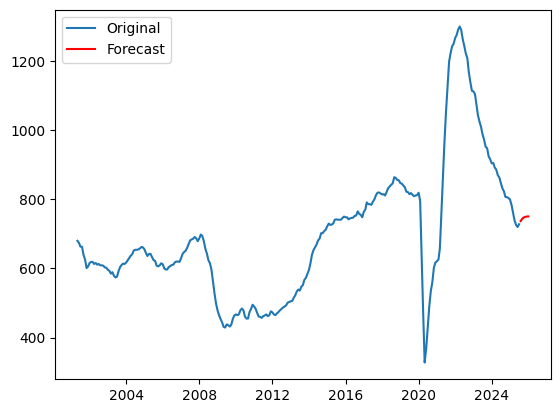

In [67]:
forecast = model_fit.forecast(steps = int(config['FORECAST']['months_to_forecast']))
print(forecast)

# Plot forecast
plt.plot(ts, label='Original')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()


To evaluate the forecast, I would calculate metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) by comparing the forecasted values against actual observed values, as these get published by the ONS. Importantly, the performance metrics should be updated as data gets revised in future vintages. In addition, the model itself should also be retrained as previous months get revised. 

To further improve the analysis, I would consider the following steps:
- Include additional relevant variables such as other macro variables and seasonal factors.
- Explicitly model the revisions process, for example by using a state space model.
- Explore more advanced forecasting models, such as Prophet or neural networks.
- Augment model with real-time data sources, such as job postings from online job boards.